In [1]:
#############################################################################
# Code created by: Jeyavinoth Jeyaratnam (The City College of New York)     #
# Last Modified Date: April 26th, 2021                                      #
# Date Created: April 26th, 2021                                            #
#############################################################################

import numpy as np 
import itertools
import scipy.io as sio
import pandas as pd 
import math 
import datetime as dt
import os
import matplotlib.pyplot as plt
from io import StringIO
import cartopy

# Functions to process the data read in from the HTML file 
def html_get_datetime(date, hour):
    if (date==""):
        return None
    else:
        if (hour is None):
            date_str = date + ' 00:00:00'
        else:
            date_str = date + f' {hour:.0f}:00:00'
        datetime = dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        return datetime


def process_input_html(cyclone_data, input_data):
    '''
    Function that process the cyclone data given in, based on the input data
    '''

    out = {'error': False}

    # try to convert the lat/lon and radius into float values, if not return error
    try: 
        lat = None if (input_data['lat'] == "") else float(input_data['lat'])
        lon = None if (input_data['lon'] == "") else float(input_data['lon'])
        radius = None if (input_data['radius'] == "") else float(input_data['radius'])
        start_hour = None if (input_data['start_hour'] == "") else int(input_data['start_hour'])
        end_hour = None if (input_data['end_hour'] == "") else int(input_data['end_hour'])
    except Exception as e:
        print(input_data['lat'], str(e))
        return {'error': True, 'mat_fig': None}

    if (start_hour is not None):
        if (start_hour%6) | (start_hour >= 24):
            return {'error': True, 'mat_fig': None, 'error_text': 'Hour should be 00/06/12/18'}
    if (end_hour is not None):
        if (end_hour%6) | (end_hour >= 24):
            return {'error': True, 'mat_fig': None, 'error_text': 'Hour should be 00/06/12/18'}

    start_datetime = html_get_datetime(input_data['start_date'], start_hour)
    end_datetime = html_get_datetime(input_data['end_date'], end_hour)

    # if lat/lon is not provided
    if (lat is None) | (lon is None):
        if (start_datetime is None):
            return {'error': True, 'mat_fig': None}
        elif (end_datetime is None):
            if (start_hour is None):
                ind = cyclone_data.cyclones_on_date(start_datetime)
            else:
                ind = cyclone_data.cyclones_on_date_and_time(start_datetime)
        else:
            ind = cyclone_data.cyclones_during_time_series(start_datetime, end_datetime)
    else:
        if (start_datetime is None):
            ind = cyclone_data.cyclones_near_point(lat, lon, radius)
        elif (end_datetime is None):
            if (start_hour is None):
                ind = cyclone_data.closest_cyclones_on_date(start_datetime, lat, lon, radius)
            else:
                ind = cyclone_data.closest_cyclones_on_date_and_time(start_datetime, lat, lon, radius)
        else:
            ind = cyclone_data.closest_cyclones_during_time_series(start_datetime, end_datetime, lat, lon, radius)

    tmp = cyclone_data.df[ind]
    cyc_max_lon, cyc_min_lon = tmp.lon.max(), tmp.lon.min()

    if (np.sum(ind) < 1):
        return {'error': True, 'error_text': 'No Cyclones Found!'}
    elif (np.sum(ind) == 1):
        ls = '*'
    else:
        ls = '-'

    # getting the unique cyclone indexes

    # plotting the data
    fig = plt.figure()
    projection = cartopy.crs.PlateCarree()
    ax = plt.subplot(111, projection=projection)

    # plotting the cyclone tracks by the detecting unique identifiers
    for uni in tmp.id.unique():
        ind = (tmp.id == uni)
        ax.plot(tmp[ind].lon, tmp[ind].lat, ls, lw=2.) 
    # ax.coastlines()
    ax.set_xlabel('Longitude [degrees east]')
    ax.set_ylabel('Latitude [degrees north]')
    ax.stock_img()
    if (lat is None) | (lon is None):
        ax.set_global()
    else:
        div = np.ceil((radius/111.11)) + 1
        print(lat, lon, radius, div)
        min_lat, max_lat, min_lon, max_lon = lat-div, lat+div, lon-div, lon+div
        if (cyc_max_lon > max_lon): max_lon = cyc_max_lon + 1
        if (cyc_min_lon < min_lon): min_lon = cyc_min_lon + 1
        if (min_lat <= -90): min_lat = -90
        if (max_lat >= 90): max_lat = 90
        if (min_lon <= -180): min_lon = -180
        if (max_lon >= 180): max_lon = 180
        print(min_lat, max_lat, min_lon, max_lon)
        ax.set_extent([min_lon, max_lon, min_lat, max_lat])

    # grabbing the data into an IO string
    imgdata = StringIO()
    fig.savefig(imgdata, format='svg')
    imgdata.seek(0)

    # returning the IO string of the image
    out['mat_fig'] = imgdata.getvalue()
    if (lat is None) | (lon is None):
        if (end_datetime is None) & (start_datetime is not None):
            out['fig_text'] = f'Cyclones on {start_datetime}'
        elif (end_datetime is not None):
            out['fig_text'] = f'Cyclones between {start_datetime} to {end_datetime}'
    else:
        if (end_datetime is None) & (start_datetime is not None):
            out['fig_text'] = f'{radius}km around ({lon:.2f}, {lat:.2f}) on {start_datetime}'
        elif (end_datetime is not None):
            out['fig_text'] = f'{radius}km around ({lon:.2f}, {lat:.2f}) from {start_datetime} to {end_datetime}'

    txtdata = StringIO()
    tmp.to_csv(txtdata, header=True)
    txtdata.seek(0)

    out['txtdata'] = txtdata

    return out

# Functions generally used by the class below
def six_hrly_timesteps(date_range):
    '''
    Loop from start to finish, six hourly.
    '''
    start_date = date_range[0]
    start_date = dt.datetime(start_date.year, start_date.month, start_date.day) + dt.timedelta(hours=math.floor(start_date.hour/6)*6)
    end_date = date_range[1] 
    end_date = dt.datetime(end_date.year, end_date.month, end_date.day) + dt.timedelta(hours=math.ceil(end_date.hour/6)*6)

    while end_date > start_date:
        start_date = start_date + dt.timedelta(hours=6)
        yield start_date

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return dt.datetime.fromordinal(int(datenum)) \
        + dt.timedelta(days=days) \
        - dt.timedelta(days=366)

def distance(lat1, lon1, lat2, lon2):
    ''' 
    Find the great circle distance between two cdts.
    '''

    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = lon1*degrees_to_radians
    theta2 = lon2*degrees_to_radians

    # getting the arc distance
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # converting arc in radians to distance in km 
    radius = 6356.766 # Radius in km
    arc_in_km = radius * arc
    
    return arc_in_km


# Class reading in all the cyclones
class Cyclones: 

    def __init__(self, input_file='allTCdict_1851_2016_no_repeat_date_6HRLY_cycclean.mat'):
        ''' 
        Cyclones class: 
        
        Reads in a .mat file that contains the cyclones information and creates a pandas dataframe, which can then be manipulated to get results as needed. 
        '''

        self.df = self.read_input_data(input_file)

    def read_input_data(self, input_file):
        ''' 
        Reading in the .mat file into a pandas dataframe.

        Input: 
        A matlab ".mat" file that contains all the detected cyclones. 

        Output: 
        A Pandas dataframe with the necessary information extracted from the ".mat" file. 
        '''

        # reading in the input_file
        data = sio.loadmat(input_file)
        data = data['cycclean'][0]

        # Full variable list
        var_list = ['nsteps', 'year', 'name', 'nsteps', 'date', 'yr', 'mon', 'day', 'time', 'min', 'stat', 'lat', 'lon', 'wnd', 'slp', \
                'fulllat', 'fulllon', 'fulldate']

        # Selected variable lists
        var_list_single = ['nsteps', 'year', 'name']
        var_list = ['date', 'yr', 'mon', 'day', 'time', 'min', 'lat', 'lon', 'wnd', 'slp', 'fulldate', 'stat'] 

        # Initializing PY Dictionary 
        py_data = {}
        py_data['id'] = []
        for var in var_list + var_list_single:
            py_data[var] = []
            
        # Loop through each structure and create list
        for i in range(data[var].shape[0]):
            nsteps = len(data['lat'][i])
            py_data['id'].extend(np.repeat(i, nsteps))
            for var in var_list_single: 
                py_data[var].extend(np.repeat(data[var][i][0][0], nsteps))
            for var in var_list: 
                if (var in ['stat']):
                    py_data[var].extend(self.convert_to_list(data['stat'][i], var='stat'))
                else:
                    py_data[var].extend(list(itertools.chain.from_iterable(data[var][i])))


        # Converting lon values from 0/360 to -180/180
        lon = np.array(py_data['lon'])

        # creating a -180 to 180 array
        lon[lon < 0] += 360
        py_data['lon'] = lon

        # creating a 0 to 360 array
        lon[lon > 180] -= 360
        py_data['lon_0_360'] = lon
        
        # creating a Pandas DataFrame from the data dictionary
        df = pd.DataFrame(py_data)

        # # creating columns with the full datetime and just the date
        df['datetimes'] = df.apply(lambda x: dt.datetime(x.yr, x.mon, x.day, int(x.time/1e2)), axis=1)
        df['datetime_date'] = df.apply(lambda x: dt.date(x.yr, x.mon, x.day), axis=1)

        return df

    def convert_to_list(self, data, var=None):
        ''' 
        Convert a single cyclone track into a list 
        '''

        out = []
        for i in data:
            # if the variable name is "stat" we have to do a special string manipulation
            if (var in ['stat']):
                s=''
                for ii in i: 
                    if (isinstance(ii, str)):
                        s+=ii
                    else:
                        s+=chr(ii)
                out.append(s)
            else: # we just convert the numpy array into a list
                out.append(i.tolist())
                
        return out

    def cyclones_on_date(self, in_date):
        '''
        Get the index of the cyclones on the given date. 

        Input: 
        A "datetime" or "date" object from the "datetime" library, ex: datetime.datetime(1999, 1, 1). 

        Output: 
        The index of the rows (of the Pandas dataframe) that matches the given date.
        '''

        ind = (self.df.yr == in_date.year) & (self.df.mon == in_date.month) & (self.df.day == in_date.day)
        return ind
    
    def cyclones_on_date_and_time(self, in_date):
        '''
        Get the index of the cyclones on the given date and time. 

        Input: 
        A "datetime" object from the "datetime" library, ex: datetime.datetime(1999, 1, 1, 6). 

        Output: 
        The index of the rows (of the Pandas dataframe) that matches the given date and time.
        '''

        ind = (self.df.yr == in_date.year) & (self.df.mon == in_date.month) & (self.df.day == in_date.day) & (self.df.time == in_date.hour*100)
        return ind
    
    def cyclones_during_time_series(self, start_date, end_date):
        '''
        Get the index of the cyclones between the start and end time 

        Input: 
        Two "datetime" object from the "datetime" library, ex: datetime.datetime(1999, 1, 1, 6). 
        1. Start datetime
        2. End datetime

        Output: 
        The index of the rows (of the Pandas dataframe) that matches the given date and time.
        '''

        date_ind = (self.df.datetimes >= start_date) & (self.df.datetimes <= end_date)
        return date_ind

    def cyclones_near_point(self, lat, lon, radius=800):
        '''
        Get the index of the cyclones, that are within a given distance from the co-ordinate.  

        Input: 
        lat - latitude of the co-ordinate
        lon - longitude of the co-ordinate
        radius - defaults to 800km, but can be changed

        Output: 
        The index of the rows (of the Pandas dataframe) that are within the given radius from the point.
        '''

        self.df['dist_from_point'] = self.df.apply(lambda x: distance(x.lat, x.lon, lat, lon), axis=1)
        return (self.df['dist_from_point'] <= radius)

    def closest_cyclones_on_date(self, in_date, lat, lon, radius=800):
        '''
        Get the index of the cyclones, that are within a given distance from the co-ordinate, on a given date.  

        Input: 
        in_date - datetime object of the date for which we need to find the cyclones
        lat - latitude of the co-ordinate
        lon - longitude of the co-ordinate
        radius - defaults to 800km, but can be changed

        Output: 
        The index of the rows (of the Pandas dataframe) that are within the given radius from the point, on a given date.
        '''
        date_ind = self.cyclones_on_date(in_date)
        dist_ind = self.cyclones_near_point(lat, lon, radius=radius)
        return (date_ind & dist_ind)
    
    def closest_cyclones_on_date_and_time(self, in_date, lat, lon, radius=800):
        '''
        Get the index of the cyclones, that are within a given distance from the co-ordinate, on a given date and time.  

        Input: 
        in_date - datetime object of the date/time for which we need to find the cyclones
        lat - latitude of the co-ordinate
        lon - longitude of the co-ordinate
        radius - defaults to 800km, around the central point, but can be changed

        Output: 
        The index of the rows (of the Pandas dataframe) that are within the given radius from the point, on a given date and time.
        '''

        date_ind = self.cyclones_on_date_and_time(in_date)
        dist_ind = self.cyclones_near_point(lat, lon, radius=radius)
        return (date_ind & dist_ind)

    def closest_cyclones_during_time_series(self, start_date, end_date, lat, lon, radius=800):
        '''
        Get the index of the cyclones that are within the start and end date, near the provided point. 

        Input: 
        start_date - start date from which I have to look for TC events
        end_date - end date till which I have to look for TC events
        lat - latitude of the co-ordinate around which to find the cyclones
        lon - longitude of the co-ordinate around which to find the cyclones
        radiius - defaults to 800km around the central point, but can be changed

        '''

        dist_ind = self.cyclones_near_point(lat, lon, radius=radius)
        date_ind = (self.df.datetimes >= start_date) & (self.df.datetimes <= end_date)
        return (date_ind & dist_ind)



In [2]:
import cartopy.crs as ccrs

In [3]:
data=pd.read_csv("C:/Users/carol/Desktop/Python_22/nyc_precip/ibtracs_masks_deliverable_submit/ibtracs.NA.list.v04r01.processed_6hrly.statslp3.csv",
                 parse_dates=["ISO_TIME"])
data

,SID,ISO_TIME,LAT,LON,STAT,WIND,SLP,storm_id
0,1851175N26270,1851-06-23 12:00:00,26.1,-90.4,,,,1
1,1851175N26270,1851-06-23 18:00:00,26.3,-91.0,,,,1
2,1851175N26270,1851-06-24 00:00:00,26.5,-91.6,,,,1
3,1851175N26270,1851-06-24 06:00:00,26.7,-92.2,,,,1
4,1851175N26270,1851-06-24 12:00:00,26.9,-92.8,,,,1
...,...,...,...,...,...,...,...,...
64315,2024317N17284,2024-11-17 12:00:00,16.7,-87.9,TS,35,1001,2303
64316,2024317N17284,2024-11-17 18:00:00,17.4,-89.0,TD,30,1003,2303
64317,2024317N17284,2024-11-18 00:00:00,18.0,-90.2,TD,25,1004,2303
64318,2024317N17284,2024-11-18 06:00:00,18.5,-91.1,DB,25,1005,2303


In [9]:
# Ensure ISO_TIME is in datetime format first
data["ISO_TIME"] = pd.to_datetime(data["ISO_TIME"])

# Then extract only the date part
data["DATE_ONLY"] = data["ISO_TIME"].dt.date

In [5]:
#add list of dates you'd like to check for a TC association 
unique_dates=np.load('unique_dates_4stations.npy', allow_pickle=True)

In [17]:
data

,SID,ISO_TIME,LAT,LON,STAT,WIND,SLP,storm_id,DATE_ONLY
0,1851175N26270,1851-06-23 12:00:00,26.1,-90.4,,,,1,1851-06-23
1,1851175N26270,1851-06-23 18:00:00,26.3,-91.0,,,,1,1851-06-23
2,1851175N26270,1851-06-24 00:00:00,26.5,-91.6,,,,1,1851-06-24
3,1851175N26270,1851-06-24 06:00:00,26.7,-92.2,,,,1,1851-06-24
4,1851175N26270,1851-06-24 12:00:00,26.9,-92.8,,,,1,1851-06-24
...,...,...,...,...,...,...,...,...,...
64315,2024317N17284,2024-11-17 12:00:00,16.7,-87.9,TS,35,1001,2303,2024-11-17
64316,2024317N17284,2024-11-17 18:00:00,17.4,-89.0,TD,30,1003,2303,2024-11-17
64317,2024317N17284,2024-11-18 00:00:00,18.0,-90.2,TD,25,1004,2303,2024-11-18
64318,2024317N17284,2024-11-18 06:00:00,18.5,-91.1,DB,25,1005,2303,2024-11-18


In [7]:
#going to manually put in the lat/lon of the central park station (our searching point) since it's not in the csv file
clat=40.77898
clon=-73.96925

In [28]:
u=unique_dates

x2=[]
d2=[]
dist=np.empty([len(u)], dtype=np.float32)
dist[:] = np.nan 
rec=np.empty([len(u)], dtype=np.float32)
rec[:] = 0

for c in range(0,len(u)):
    itc=[]
    ev=[]
    ev1=[]
    ddata=[]
    in_date=u[c]
    #try locating that in the other dataset
    #in_date=cdate
    #itc=np.where((data.yr == in_date.year) & (data.mon == in_date.month) & (data.day == in_date.day))
    itc=data[data["DATE_ONLY"]==in_date]
    id=np.unique(itc['storm_id'])
    #print(id)

    #now track radius
    #for any matching days
    if any(id)==True:
        for t in range(len(id)):
            atc=data[data['storm_id']==id[t]]
            yy=len(atc)
            #print(atc)
            new=[]
            new=atc.reset_index(drop=True)
            #for every storm id's path
            for y in range(0,yy):
                d=distance(clat,clon,new.LAT[y],new.LON[y])
                #this indexing is weird bc there will be more entries for each  
                if d<1000: 
                    #print(new)
                    dist[c]=d
                    #record track ID
                    rec[c]=id[t]
                    #append 
                    #this will have more entries than days in the record
                    x2.append(in_date)
                    d2.append(d)
            
print(d2)

[930.4218031549856, 708.1435057755684, 522.8822571852832, 277.2213542239818, 51.86827221617083, 379.48643976874394, 661.5646438415147, 929.8168744778658, 925.0054353296938, 710.6269666283787, 464.07305049586984, 220.03434761479934, 69.02143168519451, 240.2427358096288, 925.0054353296938, 710.6269666283787, 464.07305049586984, 220.03434761479934, 69.02143168519451, 240.2427358096288, 949.9683821559823, 900.963863816961, 929.3055122670764, 995.3798006132827, 949.9683821559823, 900.963863816961, 929.3055122670764, 995.3798006132827, 862.0465135437929, 851.8590417322583, 615.0249587207297, 328.74318638506384, 44.18881199487839, 213.65047896337674, 394.0193370151193, 561.9830632792716, 702.3427845815502, 855.8008660391642, 954.6544908660278, 772.0211405412091, 666.3259465193436, 508.5627257824716, 381.40603292545546, 415.4490568405992, 504.5130521122229, 662.9371090965802, 838.0197511023533, 883.3423705663124, 702.4023187691582, 517.8061398945848, 352.3447599516151, 335.07772055220573, 363.

In [29]:
#unique ID numbers
urec=np.unique(rec)
urec

array([   0., 1402., 1501., 1783., 1845., 1933., 2054., 2059., 2234.],
      dtype=float32)

In [30]:
#tc_asses500=np.unique(x2)
tc_asses1000=np.unique(x2)

[]


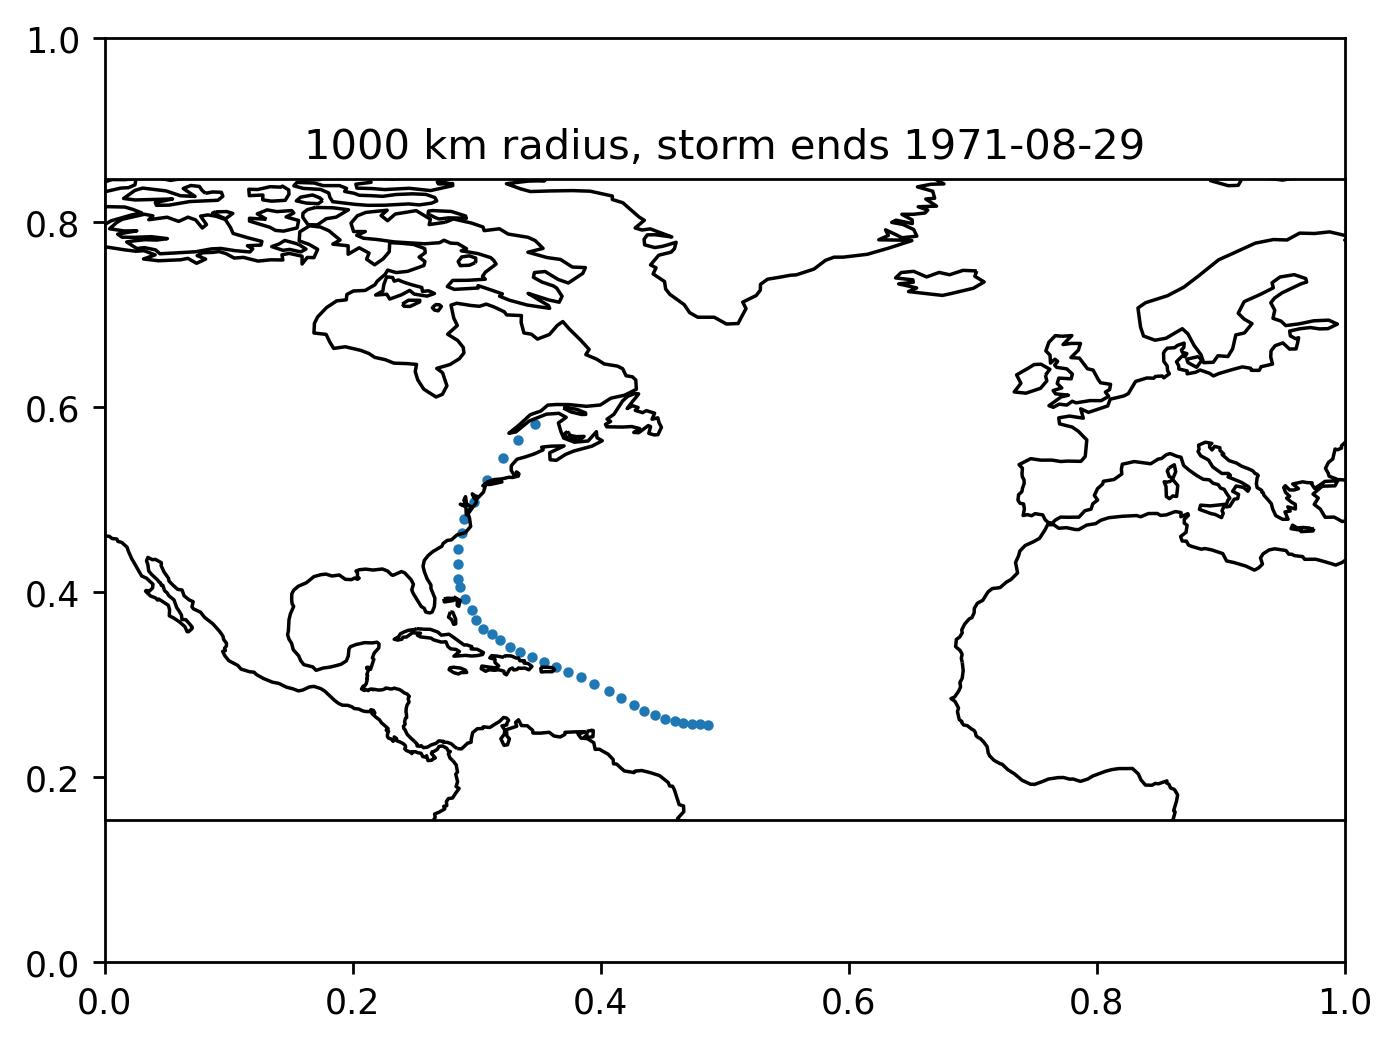

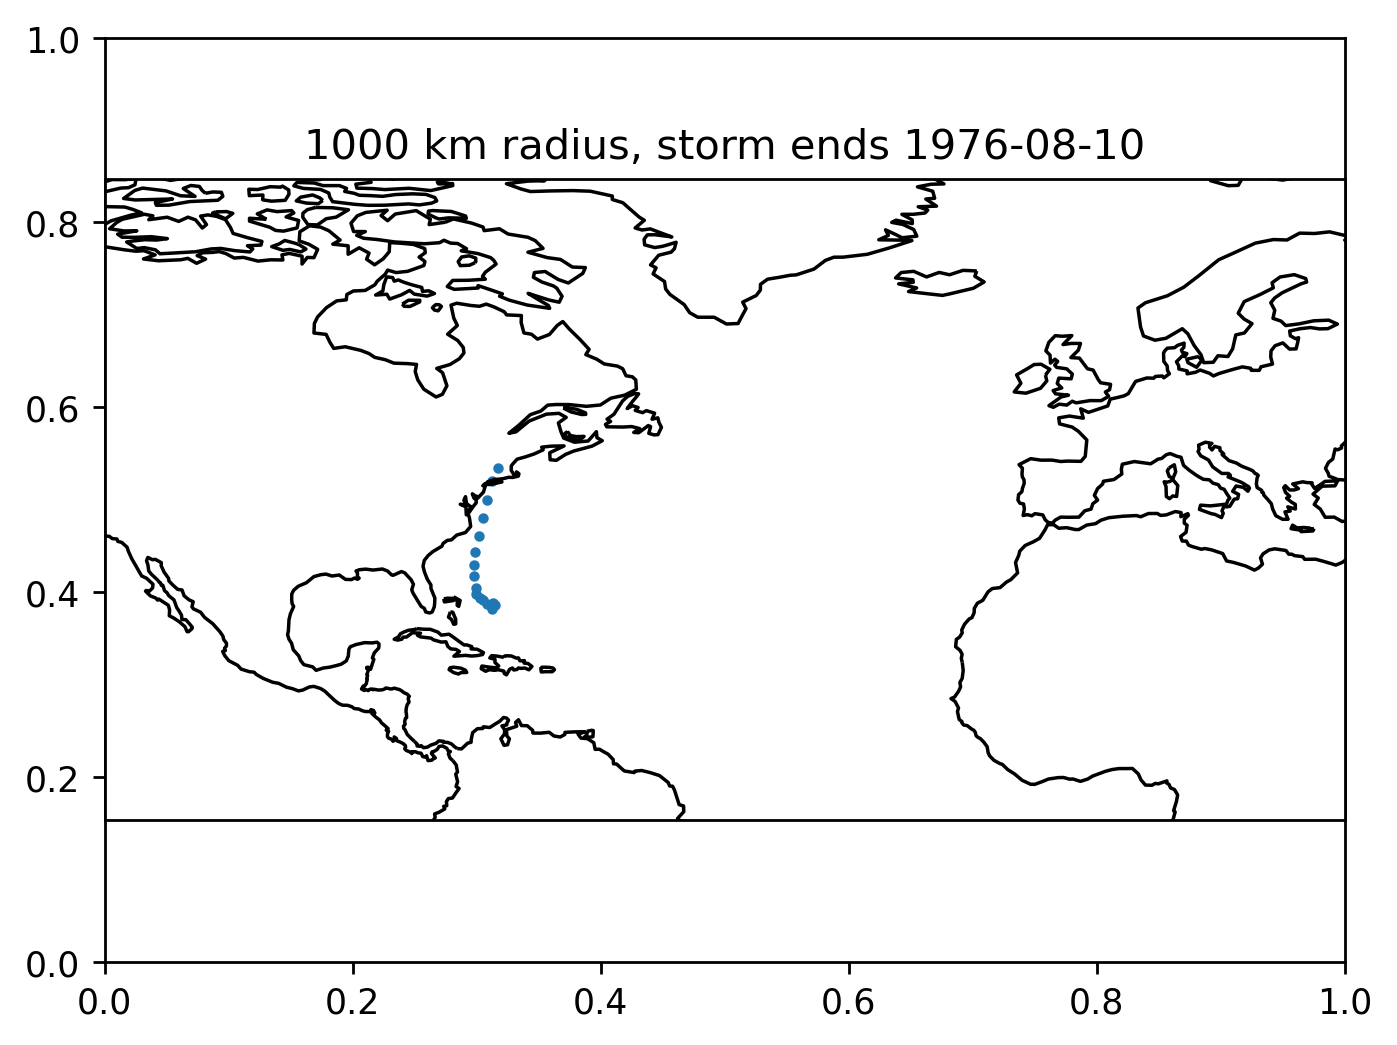

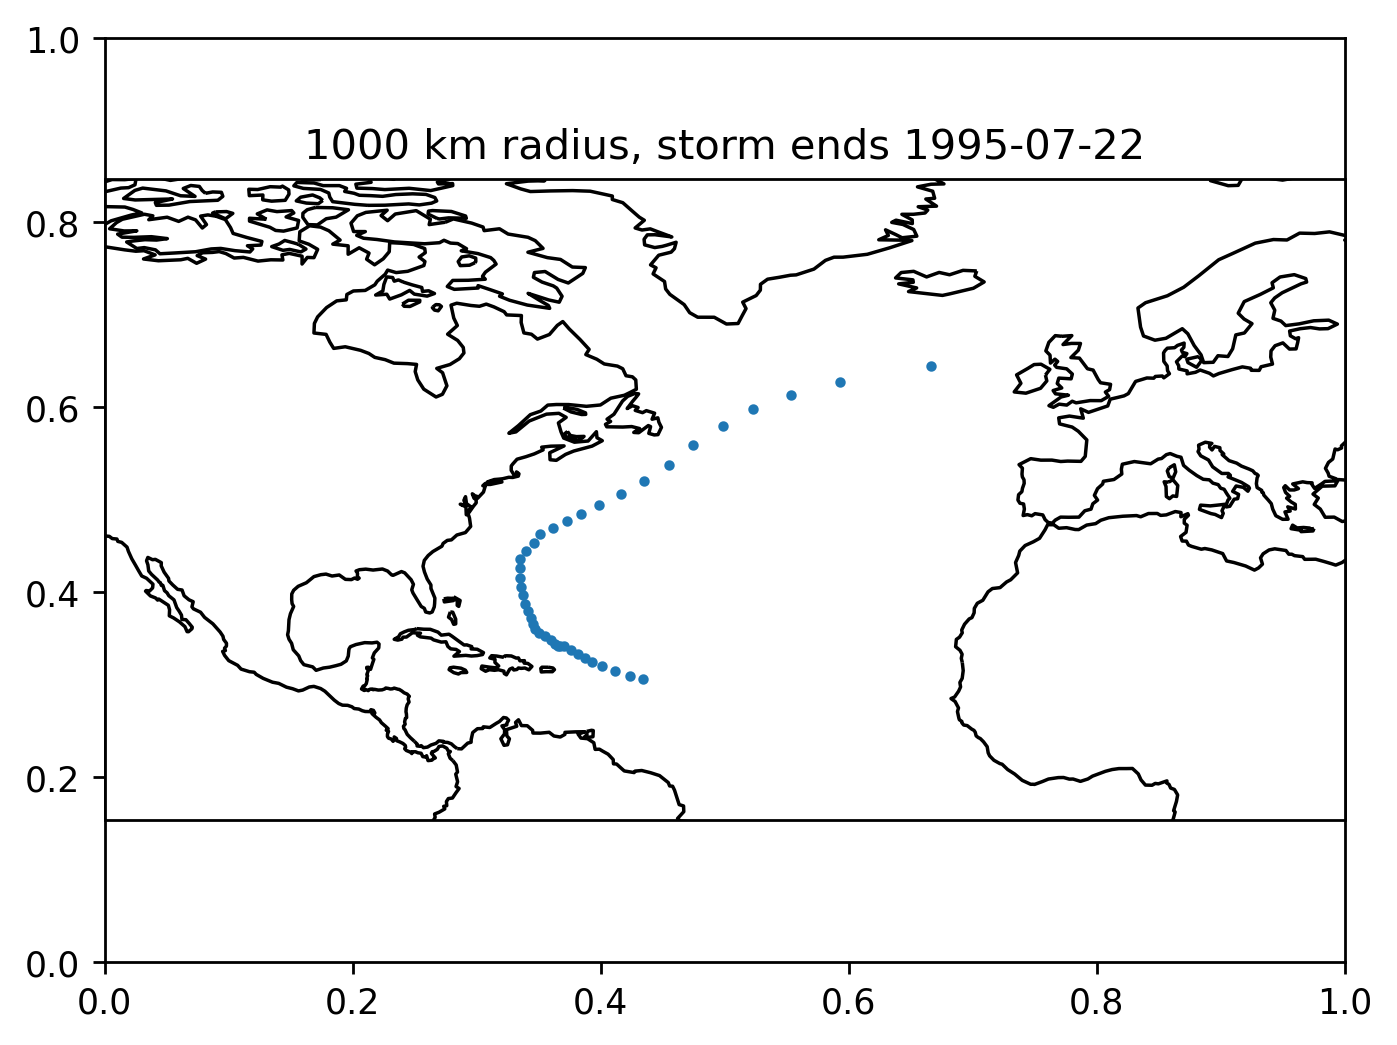

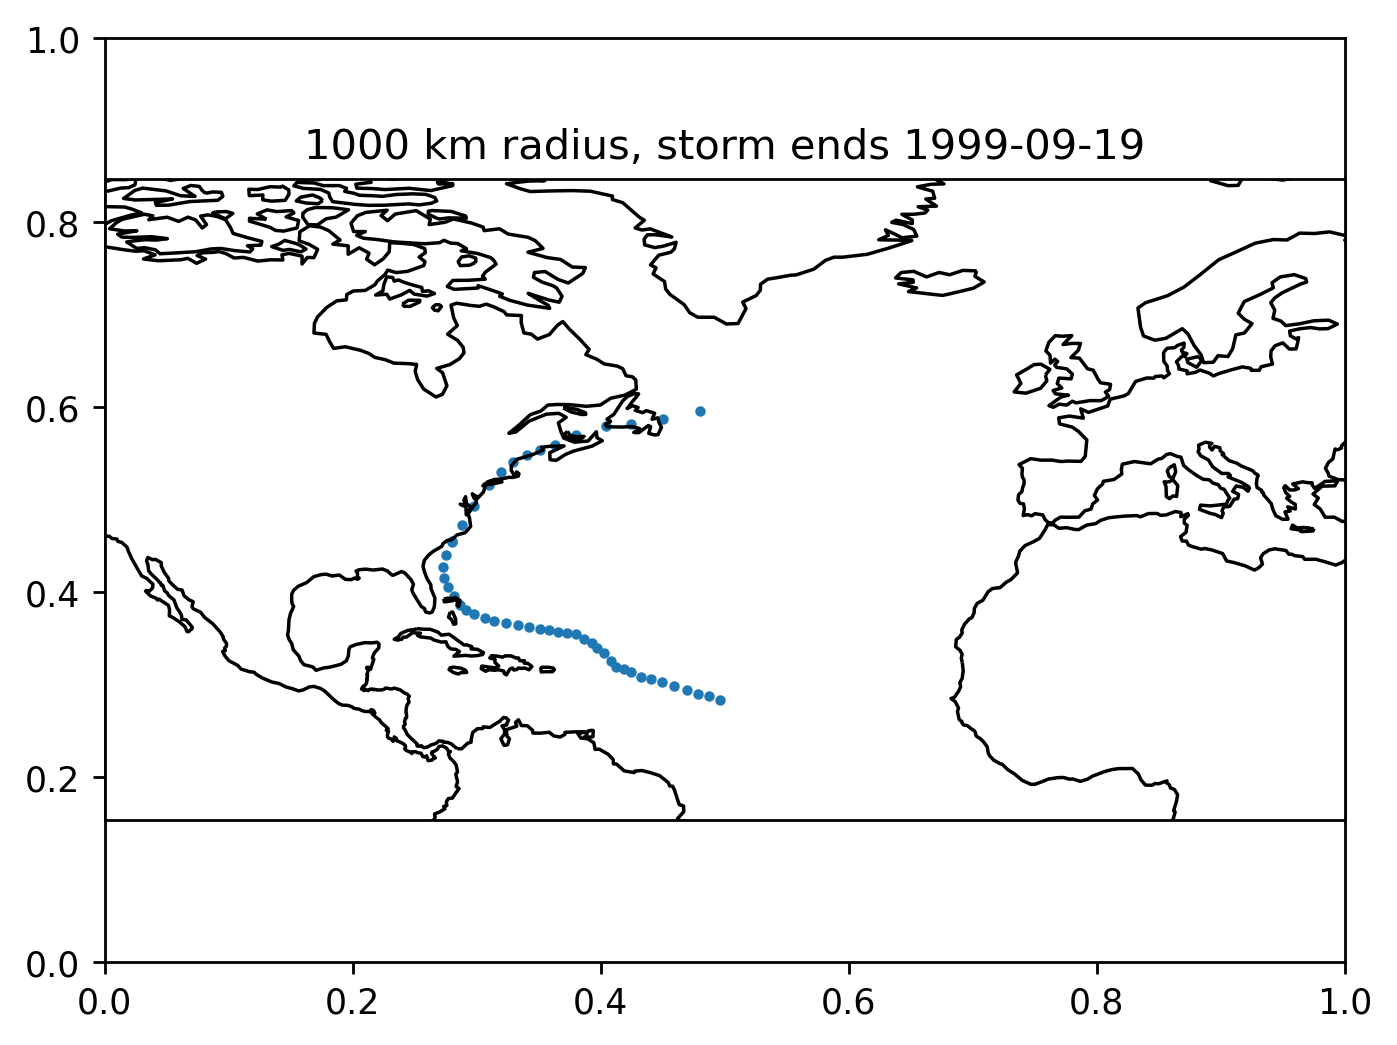

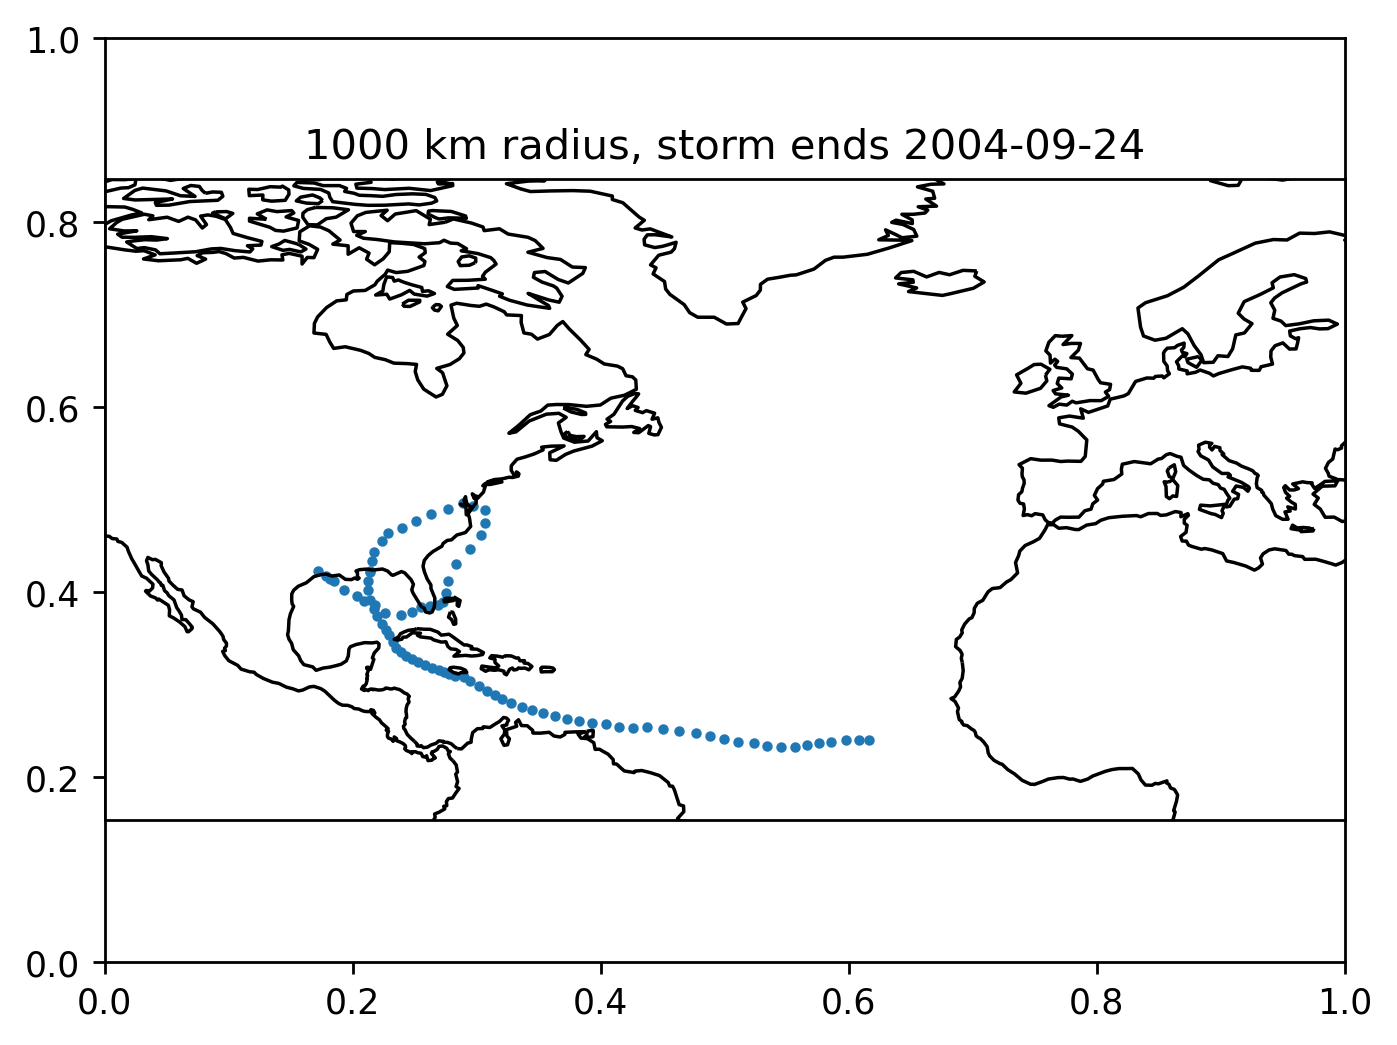

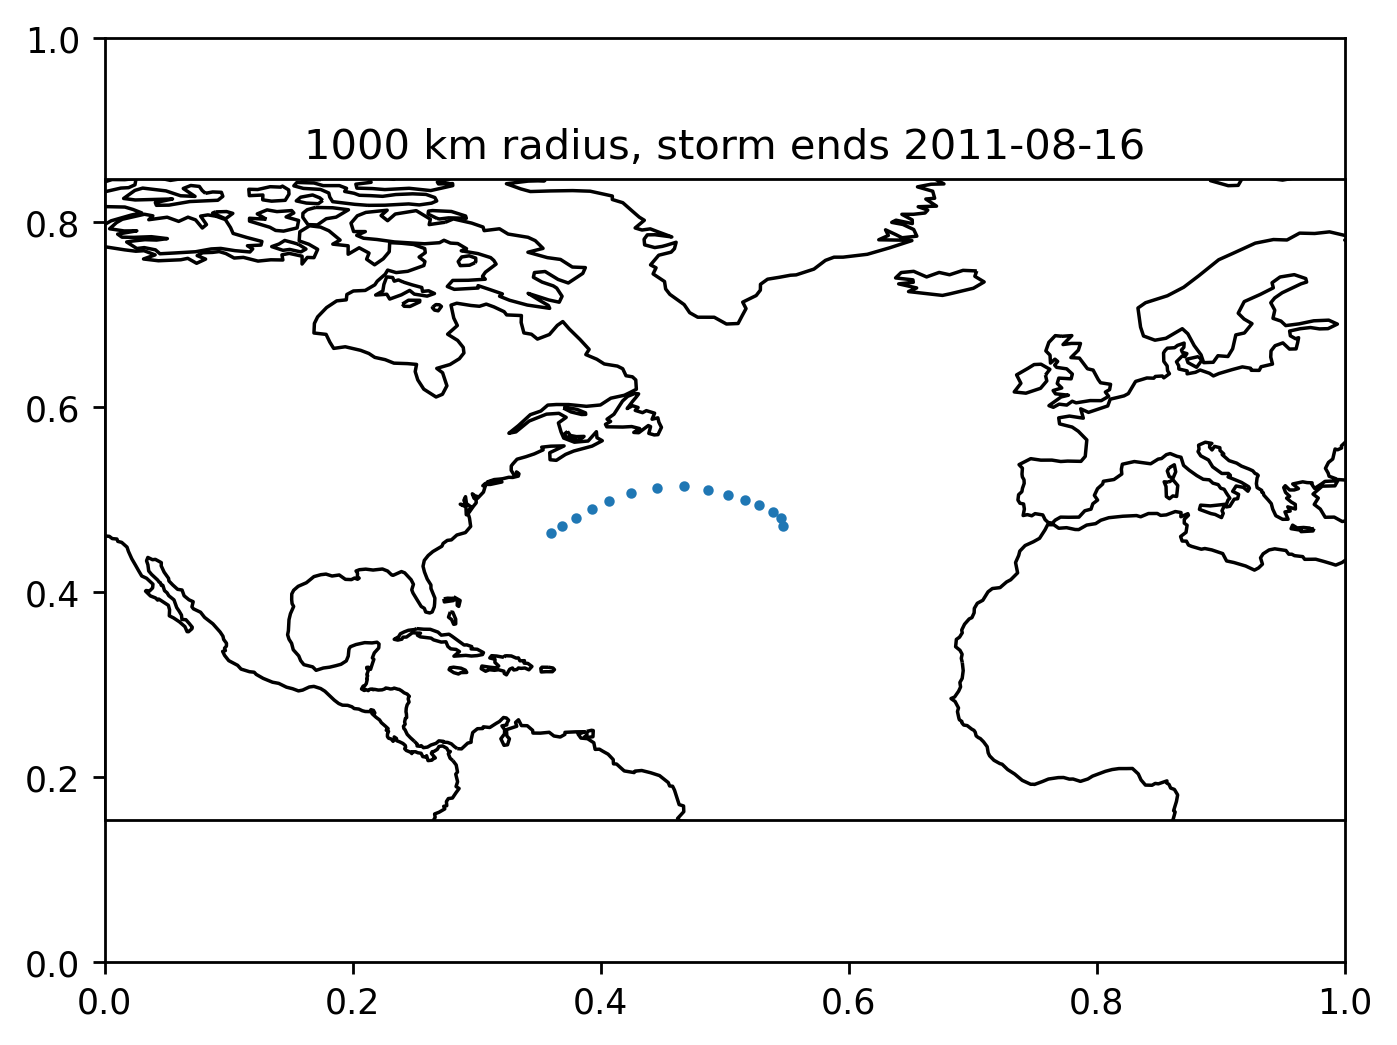

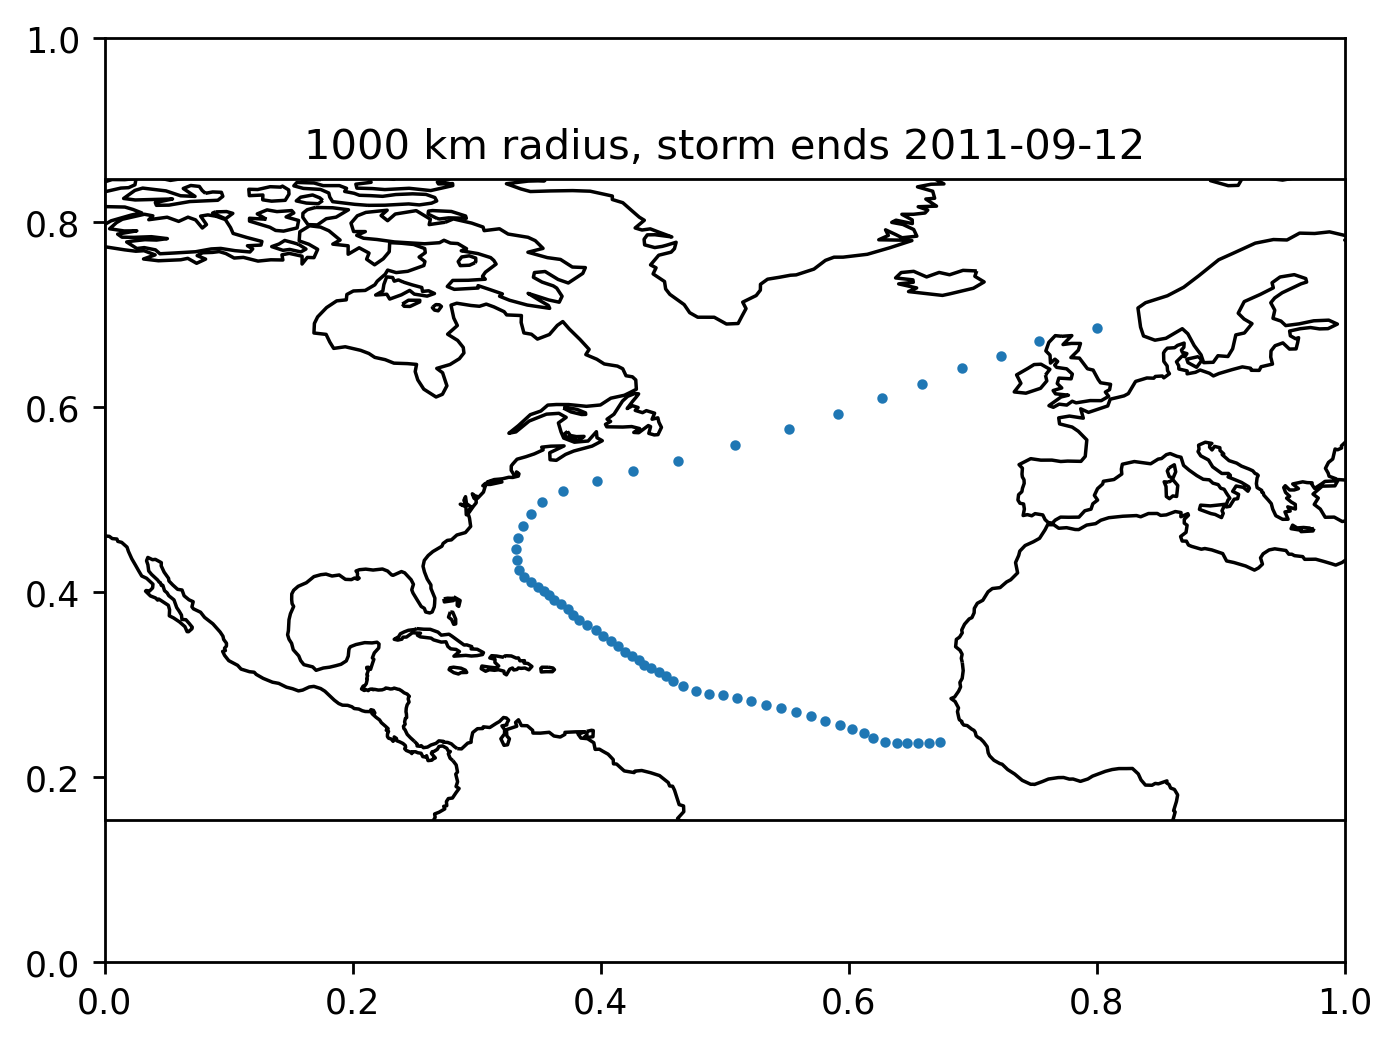

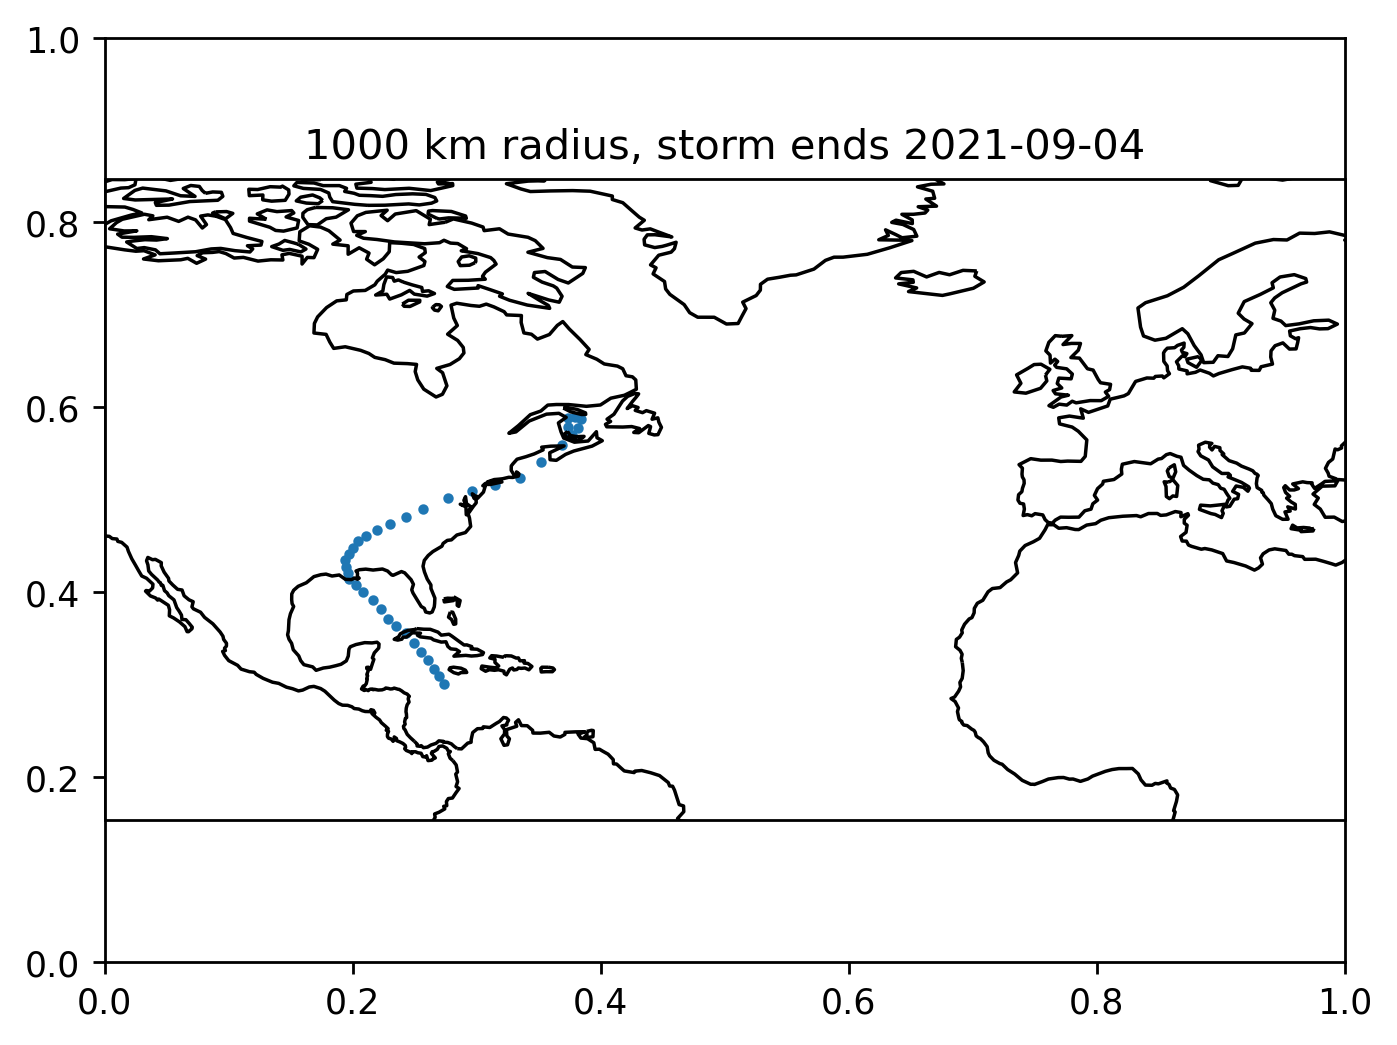

In [32]:
#plot matching tracks 

u=unique_dates

x2=[]
d2=[]
dist=np.empty([len(u)], dtype=np.float32)
dist[:] = np.nan 
rec=np.empty([len(u)], dtype=np.float32)
rec[:] = 0

#urec records 0 so start at 1
for tt in range(1,len(urec)):
    id=urec[tt]
    atc=data[data['storm_id']==id]
    new=[]
    new=atc.reset_index(drop=True)
    yy=len(new)

    fig, ax = plt.subplots(dpi=250)
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.scatter(new['LON'], new['LAT'], s=4, transform=ccrs.PlateCarree())
    ax.set_extent((-120,30,0,50)) 
    ax.coastlines()
    #plt.legend(types)
    ax.set(title=f"1000 km radius, storm ends {new["DATE_ONLY"][yy-1]}")


print(d2)

In [33]:
data

,SID,ISO_TIME,LAT,LON,STAT,WIND,SLP,storm_id,DATE_ONLY
0,1851175N26270,1851-06-23 12:00:00,26.1,-90.4,,,,1,1851-06-23
1,1851175N26270,1851-06-23 18:00:00,26.3,-91.0,,,,1,1851-06-23
2,1851175N26270,1851-06-24 00:00:00,26.5,-91.6,,,,1,1851-06-24
3,1851175N26270,1851-06-24 06:00:00,26.7,-92.2,,,,1,1851-06-24
4,1851175N26270,1851-06-24 12:00:00,26.9,-92.8,,,,1,1851-06-24
...,...,...,...,...,...,...,...,...,...
64315,2024317N17284,2024-11-17 12:00:00,16.7,-87.9,TS,35,1001,2303,2024-11-17
64316,2024317N17284,2024-11-17 18:00:00,17.4,-89.0,TD,30,1003,2303,2024-11-17
64317,2024317N17284,2024-11-18 00:00:00,18.0,-90.2,TD,25,1004,2303,2024-11-18
64318,2024317N17284,2024-11-18 06:00:00,18.5,-91.1,DB,25,1005,2303,2024-11-18


[]


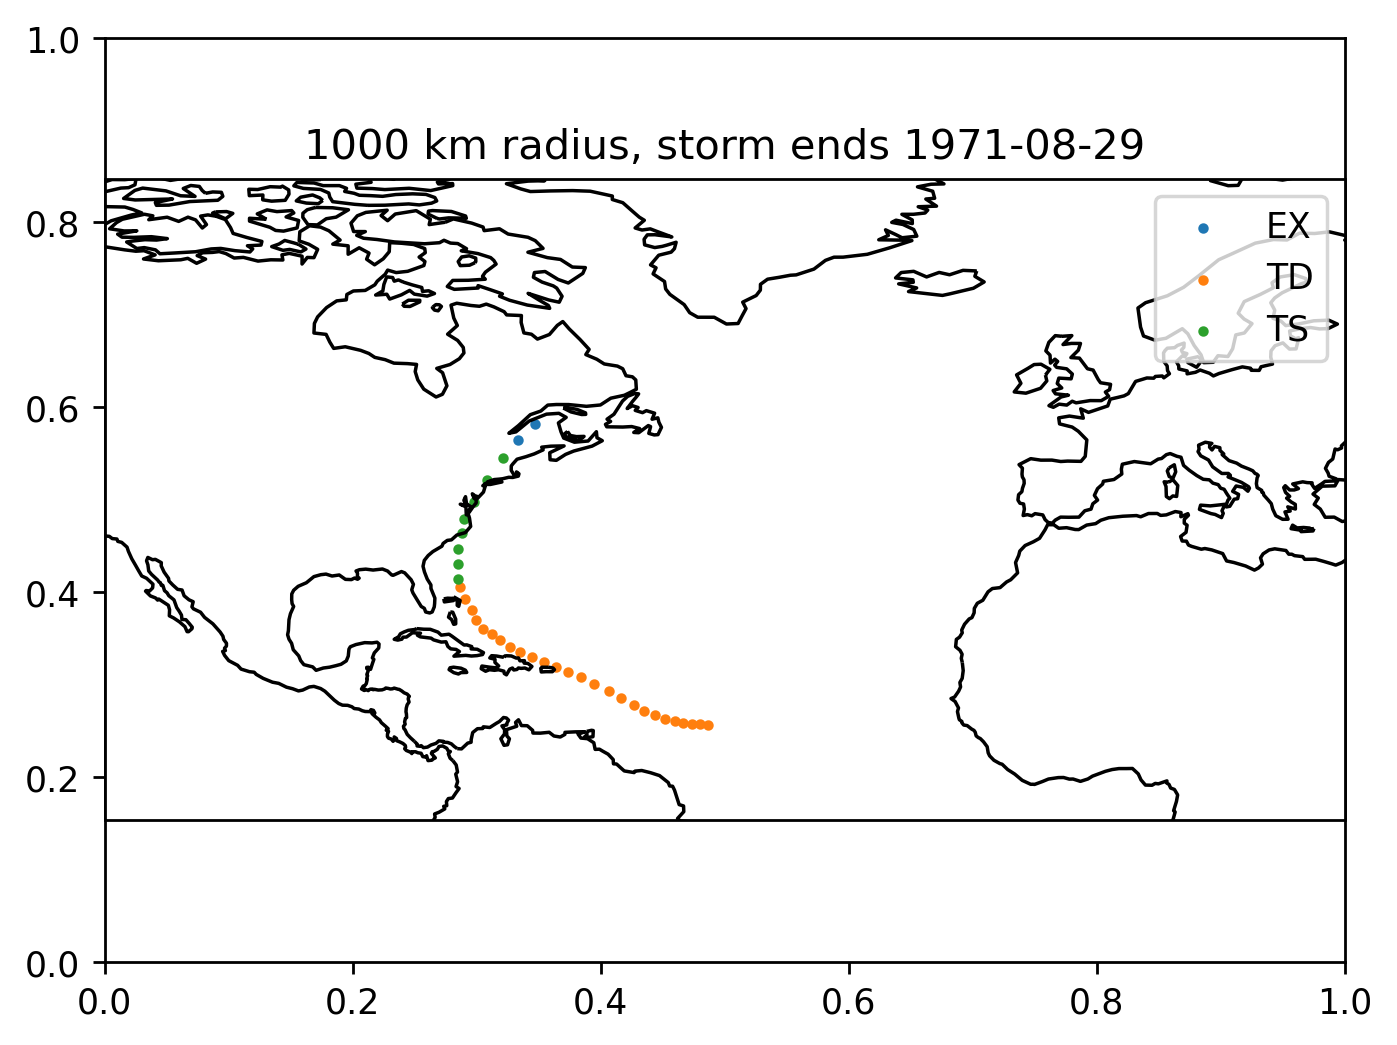

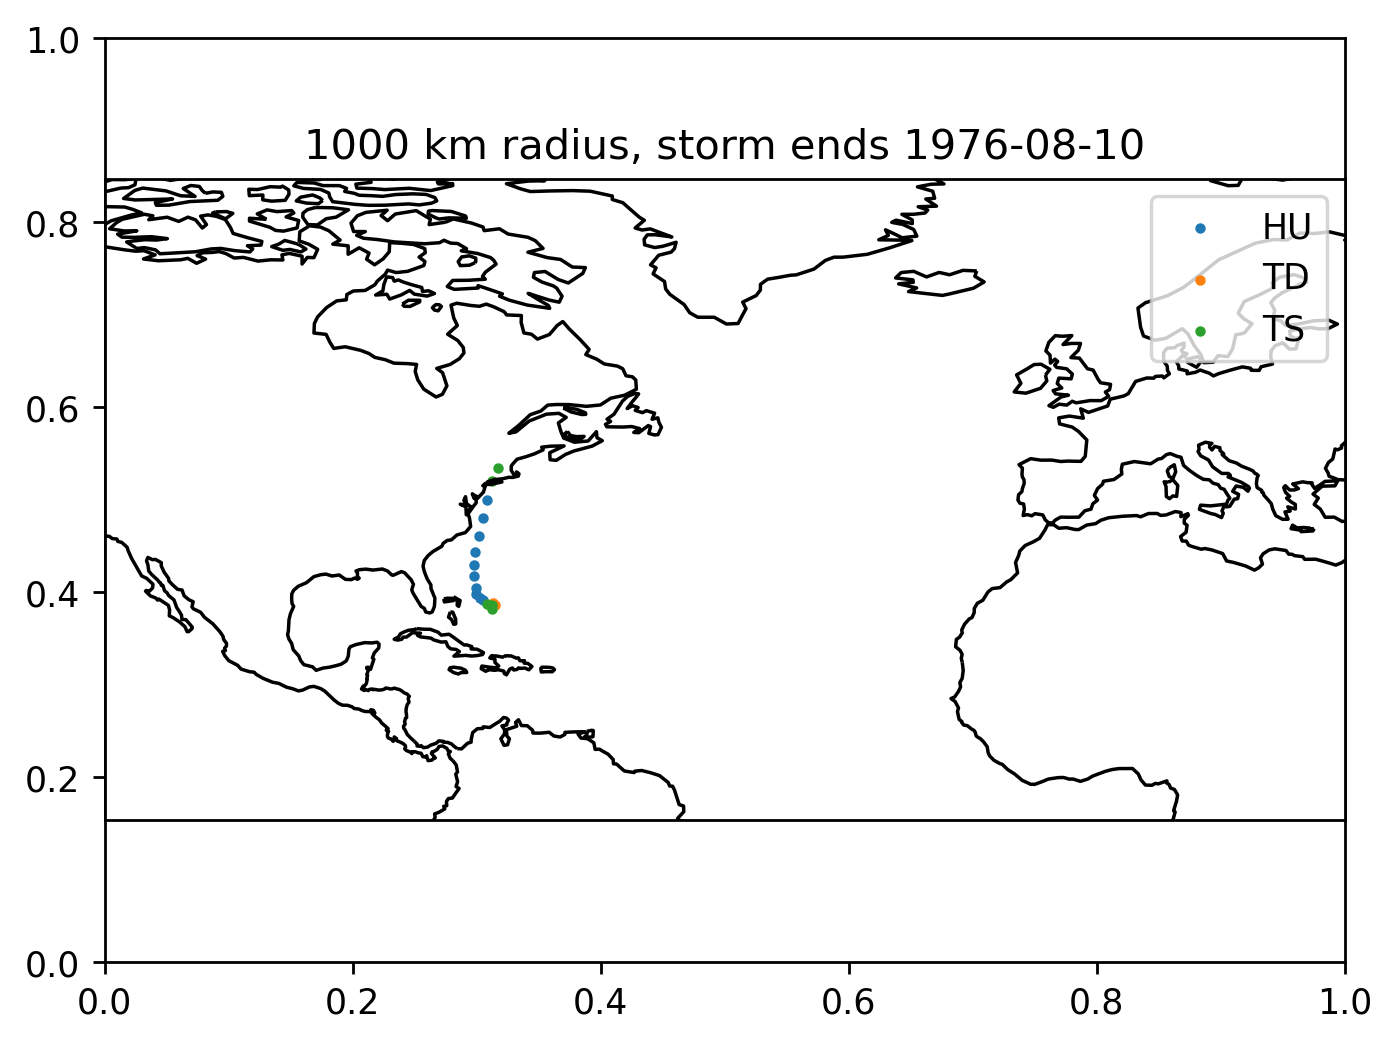

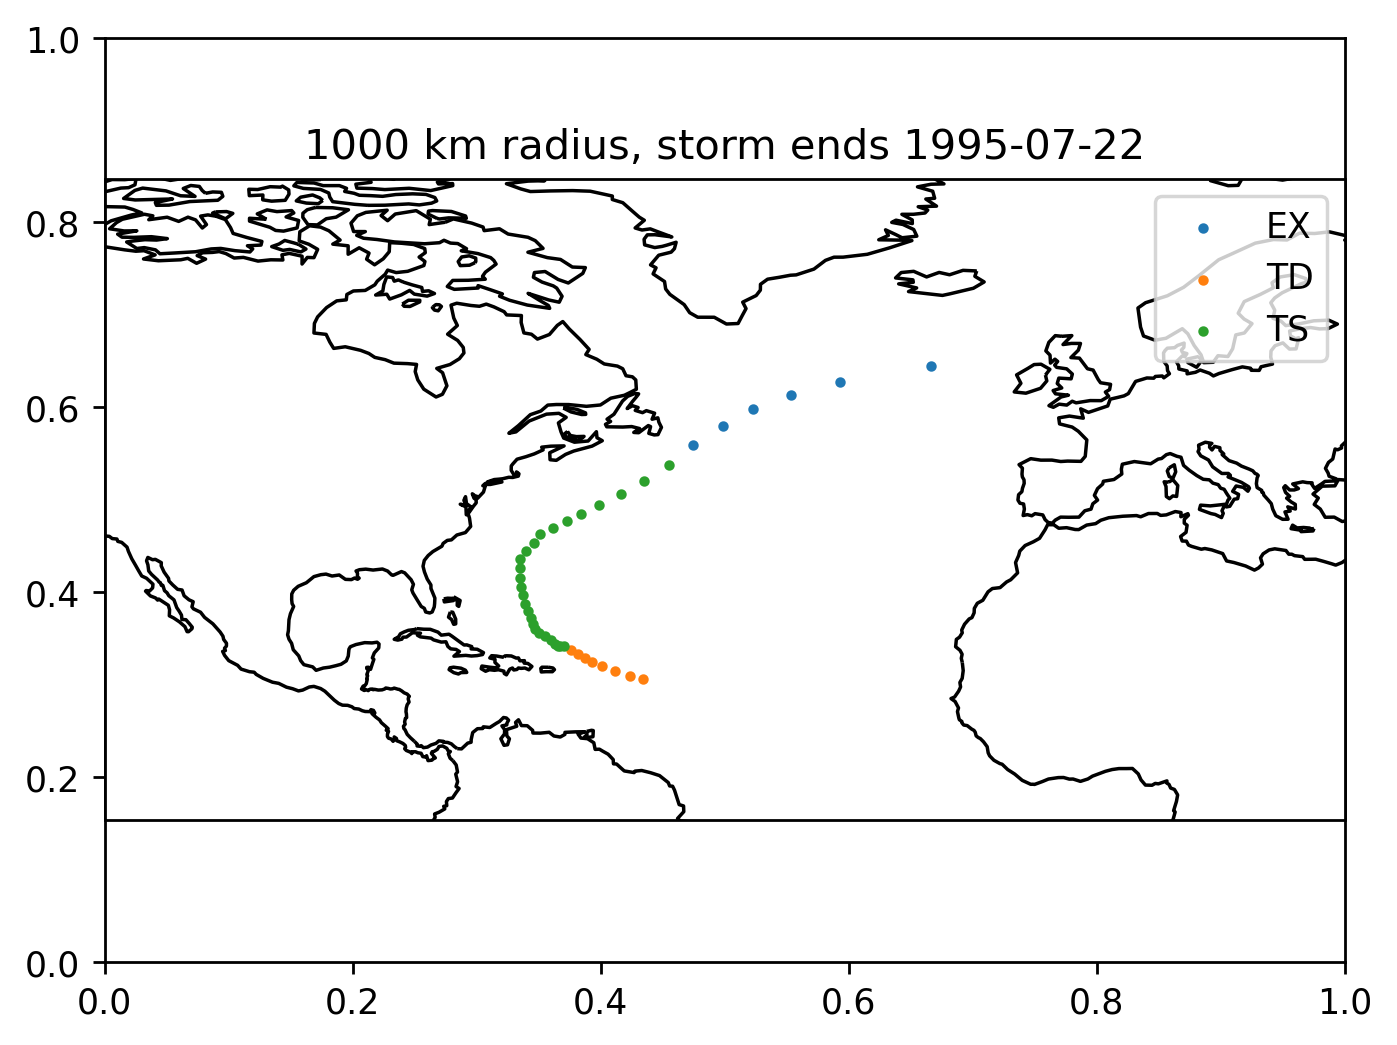

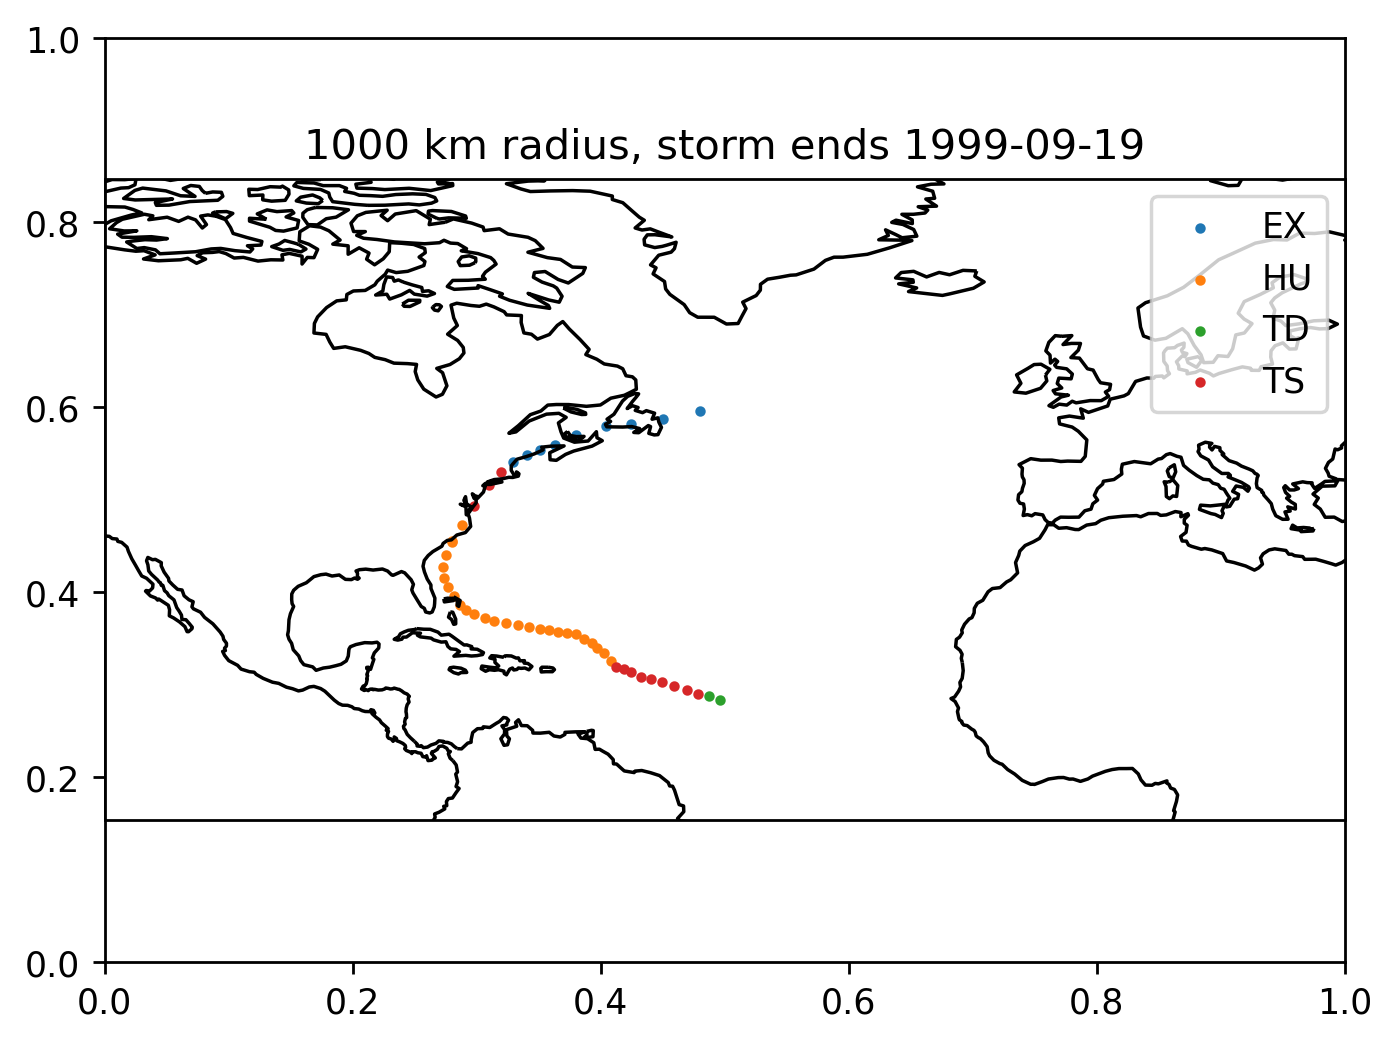

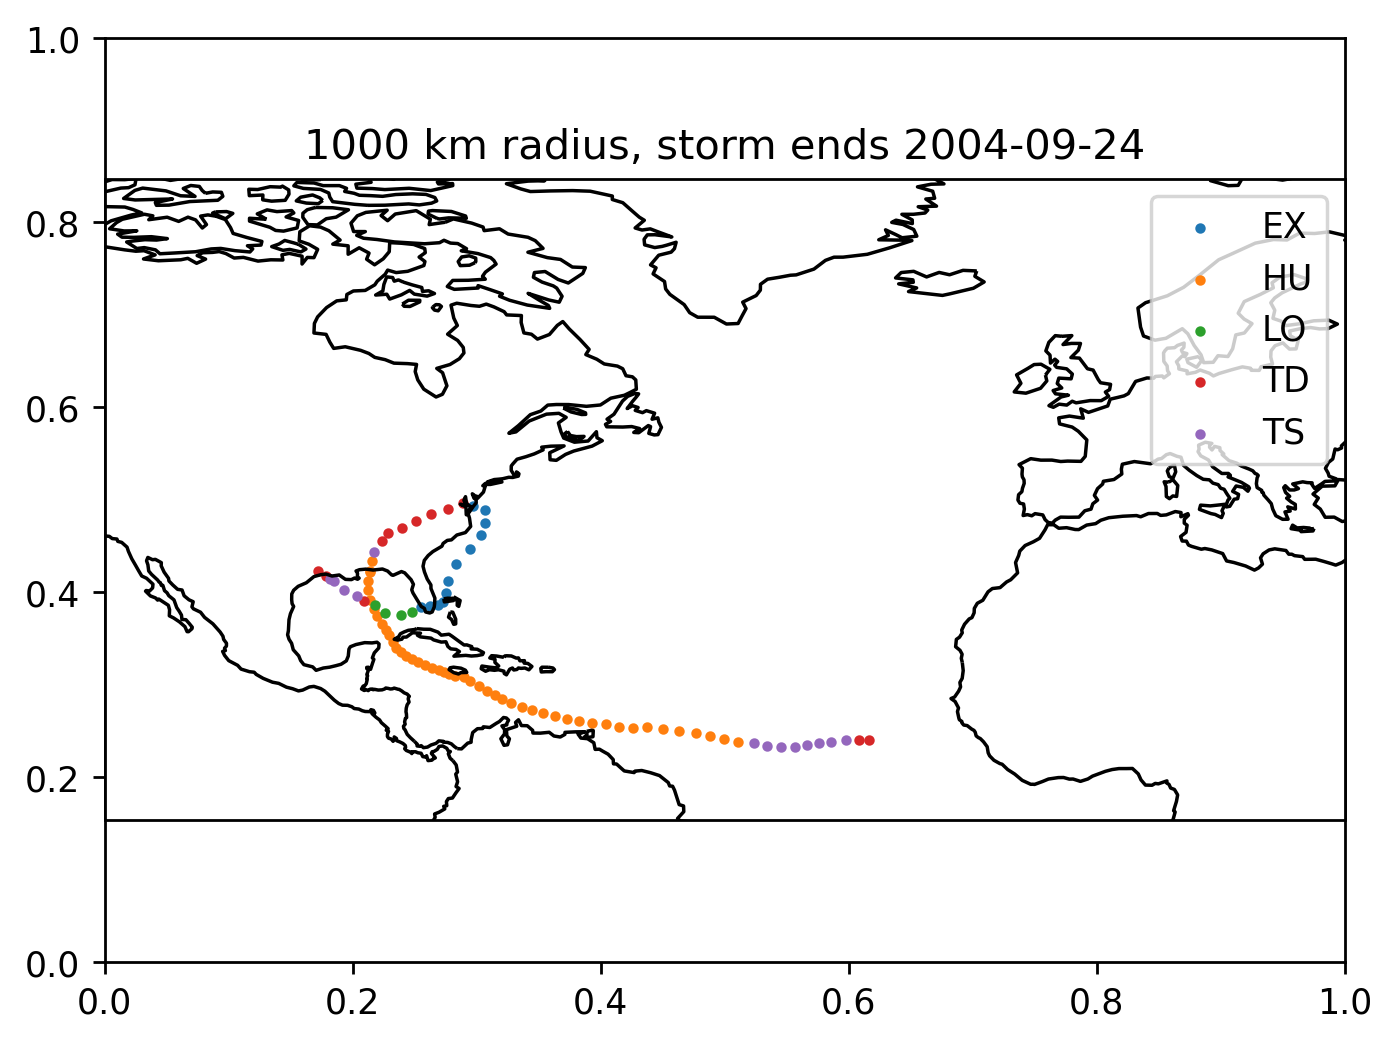

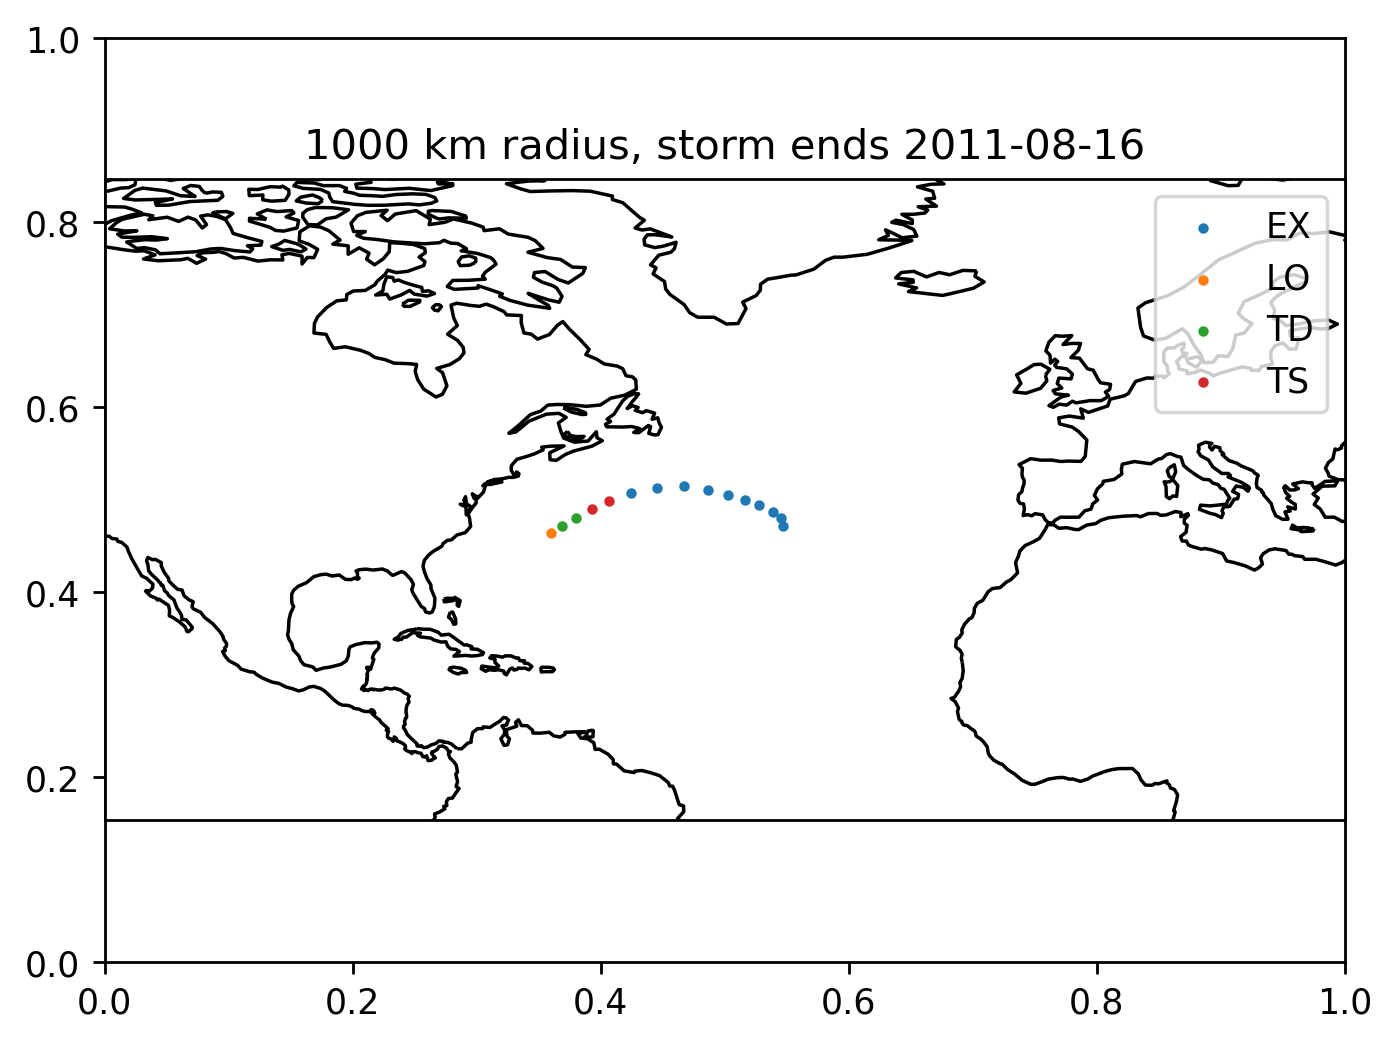

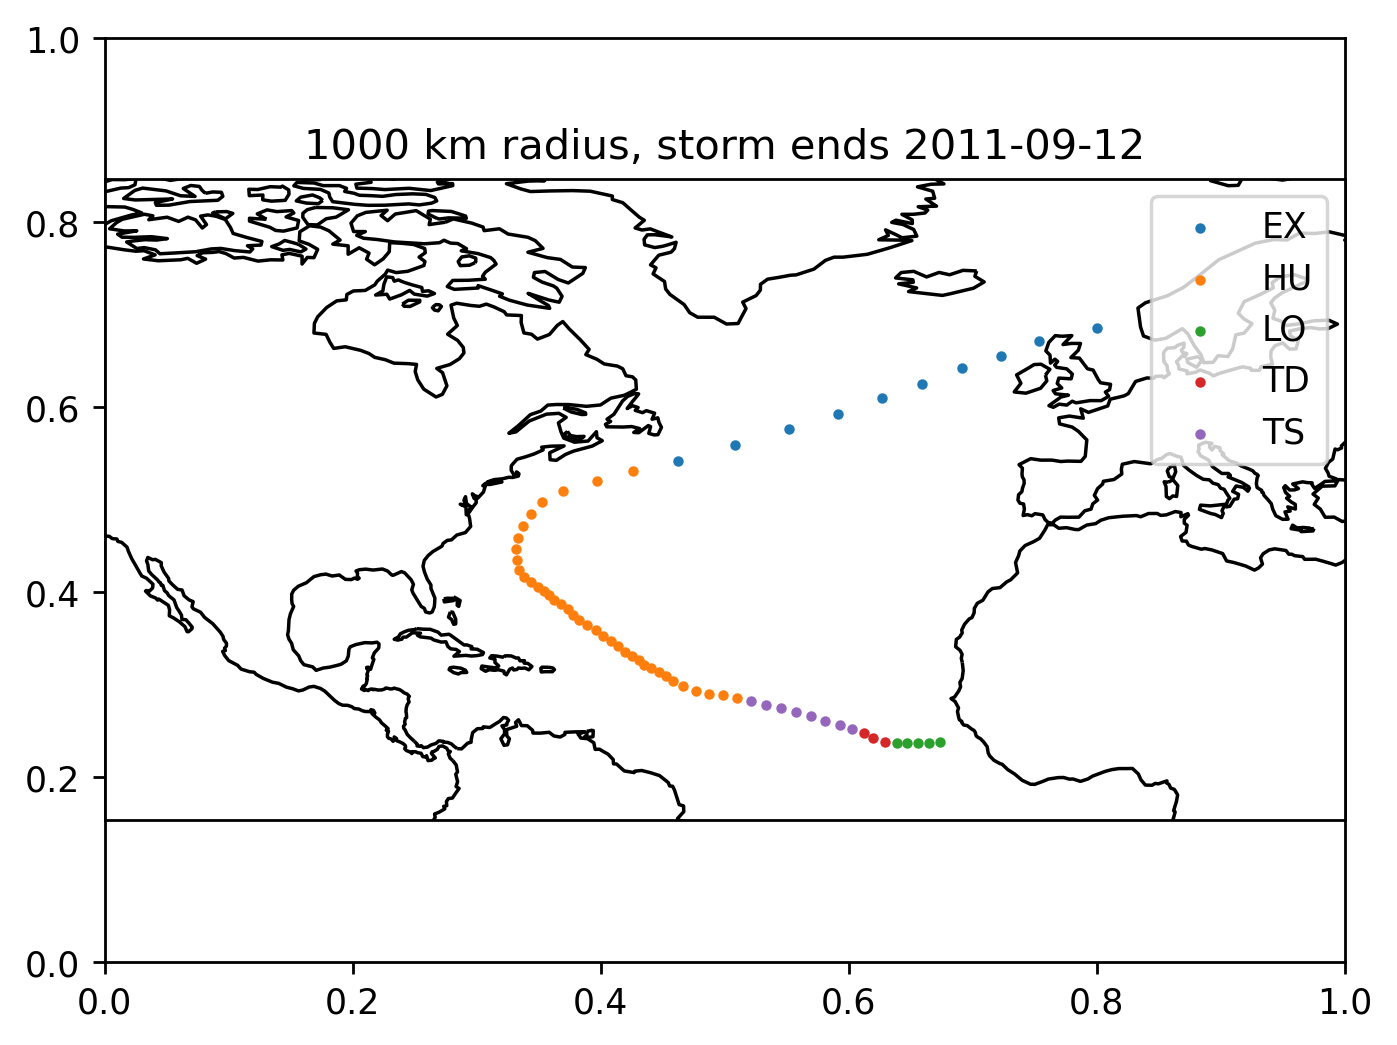

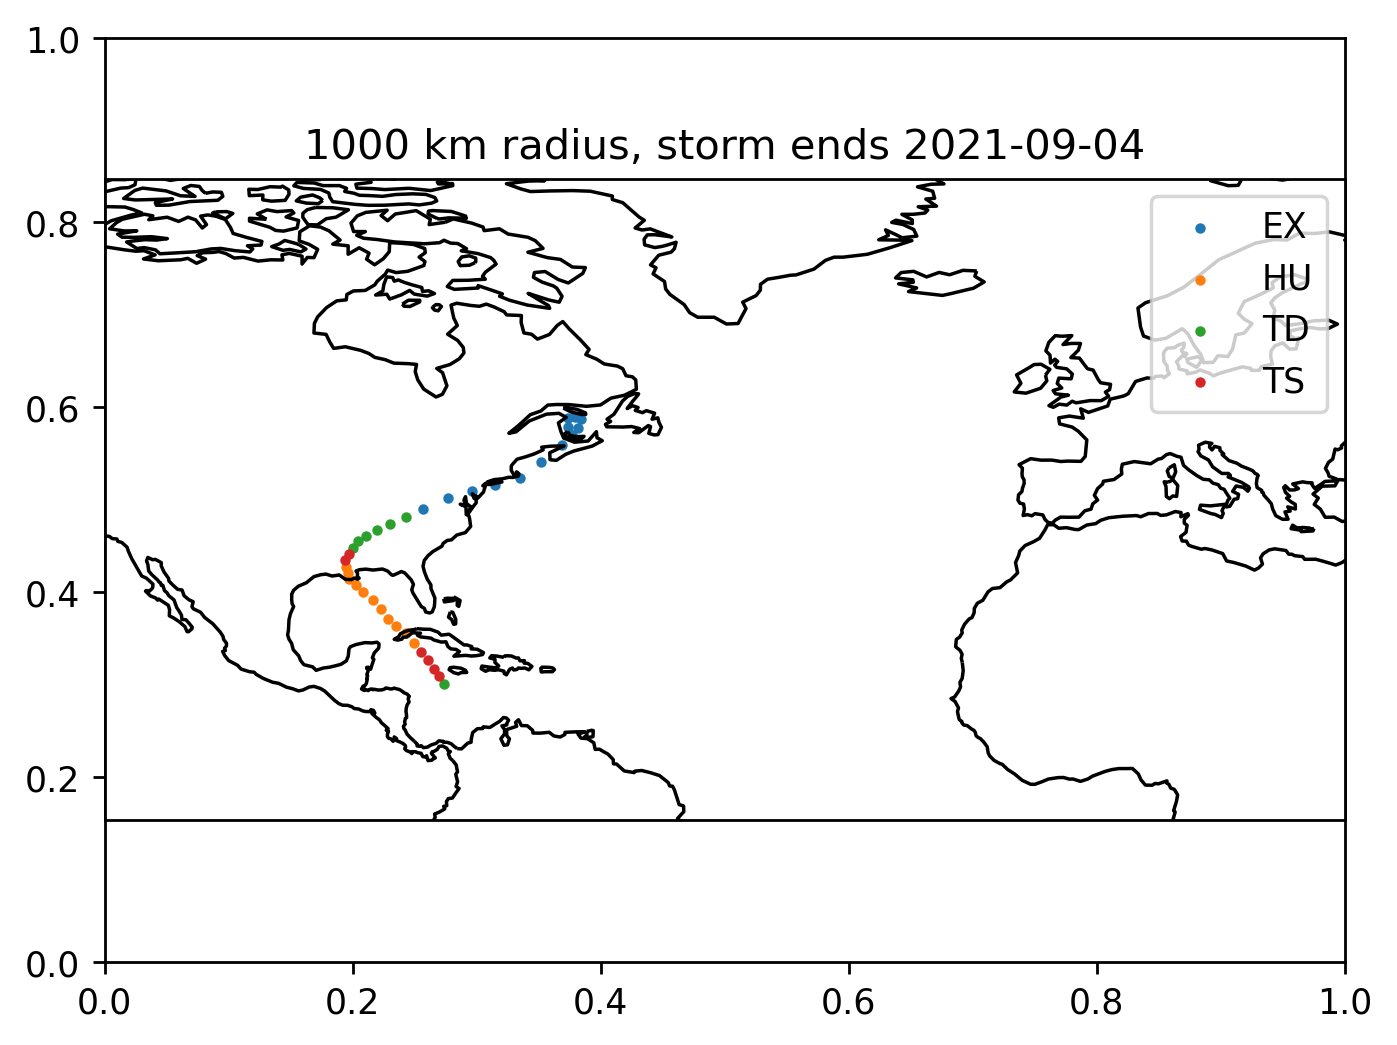

In [35]:
#plot matching tracks 
#AND DIFFERENTIATE STORM TYPE

u=unique_dates

x2=[]
d2=[]
dist=np.empty([len(u)], dtype=np.float32)
dist[:] = np.nan 
rec=np.empty([len(u)], dtype=np.float32)
rec[:] = 0

#urec records 0 so start at 1
for tt in range(1,len(urec)):
    id=urec[tt]
    atc=data[data['storm_id']==id]
    new=[]
    new=atc.reset_index(drop=True)
    yy=len(new)

    fig, ax = plt.subplots(dpi=250)
    ax = plt.axes(projection=ccrs.PlateCarree())

    #PLOT BY STORM TYPES 
    types=[]
    types=np.squeeze(np.unique(new['STAT']))

    for tt in range(0,len(types)):
        type=types[tt]
        evty=new[new['STAT']==type]
        plt.scatter(evty['LON'], evty['LAT'], s=4, transform=ccrs.PlateCarree())

    #plt.scatter(new['LON'], new['LAT'], s=4, transform=ccrs.PlateCarree())
    ax.set_extent((-120,30,0,50)) 
    ax.coastlines()
    plt.legend(types)
    ax.set(title=f"1000 km radius, storm ends {new["DATE_ONLY"][yy-1]}")


print(d2)